# Classification

This notebook conducts **Classification** on the 285,000 Political Content tweets in our dataset. The original envisioned goal of this stage was to predict whether Political tweets were **misinformation or not**, but the clustering approach in the previous notebook 04-rrp-clustering ran into some technical obstacles and we've had to switch direction.

Instead, we will attempt to **predict the GSDMM Topic Label** using all the **non-text features** we have at our disposal.


## Notebook Outline

The notebook is structured as follows:

1. Importing Libraries


2. Setting up AWS Cluster


3. Importing Dataset


4. Pre-processing


5. Building XGBoost Classifier


6. Hyperparameter Turning


7. Evaluate Best Classifier

# 1. Importing Libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

# distributed processing libraries
import coiled
import dask
from dask import distributed
from dask.distributed import Client, progress
import dask.dataframe as dd
import dask.array as da

# machine learning libraries
#import dask_xgboost
#from dask_xgboost import XGBClassifier
from dask_ml.model_selection import train_test_split #GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support, accuracy_score
from sklearn.model_selection import GridSearchCV
import sklearn
import xgboost as xgb
from xgboost.dask import DaskDMatrix

In [4]:
print('pandas version: %s' % pd.__version__)
print('numpy version: %s' % np.__version__)
print('coiled version: %s' % coiled.__version__)
print('dask version: %s' % dask.__version__)
print('sklearn version: %s' % sklearn.__version__)
print('xgboost version: %s' % xgb.__version__)

pandas version: 1.2.4
numpy version: 1.19.2
coiled version: 0.0.39.1
dask version: 2021.05.0
sklearn version: 0.24.1
xgboost version: 1.3.3


# 2. Spin Up Coiled Cluster

In [6]:
%%time
# create coiled cluster
cluster = coiled.Cluster(
    name='cap3-clustering',
    shutdown_on_close=False,
    configuration="cap3-clustering-s2_8-w4_16",
    n_workers=25,
    scheduler_options={"idle_timeout": "2 hours"}
)

Output()

Found software environment build


CPU times: user 26.2 s, sys: 6.96 s, total: 33.1 s
Wall time: 4min 10s


In [7]:
# connect cluster to Dask
client = Client(cluster)
print('Dashboard:', client.dashboard_link)

Dashboard: http://ec2-3-135-61-20.us-east-2.compute.amazonaws.com:8787


# 3. Importing Dataset

In [8]:
ddf = dd.read_parquet('s3://twitter-saudi-us-east-2/processed/df_political_for_clustering_preprocessed_partitioned.parquet',
                      chunksize='64MB',
                      engine='pyarrow'
).persist()

# 4. Pre-Processing

We'll begin by preprocessing our data so it's ready to feed into our classifier.

Specifically, we will:
1. Subset features of interest
2. Check for NaNs
3. Check data types
4. Convert to Dask Arrays
5. Create Train/Test Splits

## 4.1. Get Features of Interest

Let's subset all features other than the Tf-Idf vectors.

In [9]:
ddf.head()

,appearance_count,user_tweet_count,timestamp_counts,follower_count,following_count,flagged,0,1,2,3,...,dialect_pred_MUS,dialect_pred_RAB,dialect_pred_RIY,dialect_pred_SAL,dialect_pred_SAN,dialect_pred_SFX,dialect_pred_TRI,dialect_pred_TUN,sentiment_pred_neutral,sentiment_pred_positive
0,1,257890,35994.0,9007.0,8821.0,1.0,0.305829,0.23567,0.25127,0.260224,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,1698,17.0,616.0,1668.0,1.0,0.000000,0.00000,0.00000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,4,31135,3744.0,2370.0,3492.0,1.0,0.000000,0.00000,0.00000,0.000000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,1,4982,110.0,168.0,408.0,1.0,0.000000,0.00000,0.00000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,13403,1139.0,1257.0,539.0,1.0,0.000000,0.00000,0.00000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
# subset features of interest
ddf_notext =   ddf[['appearance_count',
                    'user_tweet_count',
                    'timestamp_counts',
                    'follower_count',
                    'following_count',
                    'gsdmm_topic_11', 
                    'gsdmm_topic_12', 
                    'gsdmm_topic_18',
                    'dialect_pred_ALG', 
                    'dialect_pred_ALX', 
                    'dialect_pred_AMM',
                    'dialect_pred_ASW', 
                    'dialect_pred_BAG', 
                    'dialect_pred_BAS',
                    'dialect_pred_BEI', 
                    'dialect_pred_BEN', 
                    'dialect_pred_CAI',
                    'dialect_pred_DAM', 
                    'dialect_pred_DOH', 
                    'dialect_pred_FES',
                    'dialect_pred_JED', 
                    'dialect_pred_JER', 
                    'dialect_pred_KHA',
                    'dialect_pred_MOS', 
                    'dialect_pred_MSA', 
                    'dialect_pred_MUS',
                    'dialect_pred_RAB', 
                    'dialect_pred_RIY', 
                    'dialect_pred_SAL',
                    'dialect_pred_SAN', 
                    'dialect_pred_SFX', 
                    'dialect_pred_TRI',
                    'dialect_pred_TUN', 
                    'sentiment_pred_neutral',
                    'sentiment_pred_positive']]

In [11]:
ddf_notext.persist()

,appearance_count,user_tweet_count,timestamp_counts,follower_count,following_count,gsdmm_topic_11,gsdmm_topic_12,gsdmm_topic_18,dialect_pred_ALG,dialect_pred_ALX,dialect_pred_AMM,dialect_pred_ASW,dialect_pred_BAG,dialect_pred_BAS,dialect_pred_BEI,dialect_pred_BEN,dialect_pred_CAI,dialect_pred_DAM,dialect_pred_DOH,dialect_pred_FES,dialect_pred_JED,dialect_pred_JER,dialect_pred_KHA,dialect_pred_MOS,dialect_pred_MSA,dialect_pred_MUS,dialect_pred_RAB,dialect_pred_RIY,dialect_pred_SAL,dialect_pred_SAN,dialect_pred_SFX,dialect_pred_TRI,dialect_pred_TUN,sentiment_pred_neutral,sentiment_pred_positive
npartitions=25,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
11376,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
273024,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284385,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


We'll have to turn the multiple topic columns into a single **target feature** column. 

Seeing as we have 4 different topic classes, this will be a **multi-class classification problem**.

Our classifier requires the labels to be within the range 0, num_class, so will jot down here the reference:

- Label 0 = Topic 4
- Label 1 = Topic 11
- Label 2 = Topic 12
- Label 3 = Topic 18

In [12]:
# create topic column
ddf_notext['topic'] = 0

In [13]:
# define function to apply across each row in partition
def map_topic(row):
    if row['gsdmm_topic_11'] == 1:
        row['topic'] = 1
    elif row['gsdmm_topic_12'] == 1:
        row['topic'] = 2
    elif row['gsdmm_topic_18'] == 1:
        row['topic'] = 3
    else:
        row['topic'] = 0
    return row

In [14]:
# define function to map across each partition in dask dataframe
def map_topics(df):
    df = df.apply(map_topic, axis=1)
    return df

In [15]:
# map across all partitions
ddf_notext = ddf_notext.map_partitions(map_topics)
ddf_notext.persist()

,appearance_count,user_tweet_count,timestamp_counts,follower_count,following_count,gsdmm_topic_11,gsdmm_topic_12,gsdmm_topic_18,dialect_pred_ALG,dialect_pred_ALX,dialect_pred_AMM,dialect_pred_ASW,dialect_pred_BAG,dialect_pred_BAS,dialect_pred_BEI,dialect_pred_BEN,dialect_pred_CAI,dialect_pred_DAM,dialect_pred_DOH,dialect_pred_FES,dialect_pred_JED,dialect_pred_JER,dialect_pred_KHA,dialect_pred_MOS,dialect_pred_MSA,dialect_pred_MUS,dialect_pred_RAB,dialect_pred_RIY,dialect_pred_SAL,dialect_pred_SAN,dialect_pred_SFX,dialect_pred_TRI,dialect_pred_TUN,sentiment_pred_neutral,sentiment_pred_positive,topic
npartitions=25,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
11376,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
273024,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284385,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [16]:
# verify
ddf_notext.head()

,appearance_count,user_tweet_count,timestamp_counts,follower_count,following_count,gsdmm_topic_11,gsdmm_topic_12,gsdmm_topic_18,dialect_pred_ALG,dialect_pred_ALX,...,dialect_pred_RAB,dialect_pred_RIY,dialect_pred_SAL,dialect_pred_SAN,dialect_pred_SFX,dialect_pred_TRI,dialect_pred_TUN,sentiment_pred_neutral,sentiment_pred_positive,topic
0,1.0,257890.0,35994.0,9007.0,8821.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.0,1698.0,17.0,616.0,1668.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0
2,4.0,31135.0,3744.0,2370.0,3492.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,3.0
3,1.0,4982.0,110.0,168.0,408.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
4,1.0,13403.0,1139.0,1257.0,539.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


Excellent, that worked.

## 4.2. Check for NaNs

In [17]:
ddf_notext.isnull().sum().compute()

appearance_count           0
user_tweet_count           0
timestamp_counts           0
follower_count             0
following_count            0
gsdmm_topic_11             0
gsdmm_topic_12             0
gsdmm_topic_18             0
dialect_pred_ALG           0
dialect_pred_ALX           0
dialect_pred_AMM           0
dialect_pred_ASW           0
dialect_pred_BAG           0
dialect_pred_BAS           0
dialect_pred_BEI           0
dialect_pred_BEN           0
dialect_pred_CAI           0
dialect_pred_DAM           0
dialect_pred_DOH           0
dialect_pred_FES           0
dialect_pred_JED           0
dialect_pred_JER           0
dialect_pred_KHA           0
dialect_pred_MOS           0
dialect_pred_MSA           0
dialect_pred_MUS           0
dialect_pred_RAB           0
dialect_pred_RIY           0
dialect_pred_SAL           0
dialect_pred_SAN           0
dialect_pred_SFX           0
dialect_pred_TRI           0
dialect_pred_TUN           0
sentiment_pred_neutral     0
sentiment_pred

No NaNs in any of our columns. Excellent, let's proceed.

## 4.3. Check Data Types

In [18]:
ddf_notext.dtypes

appearance_count           float64
user_tweet_count           float64
timestamp_counts           float64
follower_count             float64
following_count            float64
gsdmm_topic_11             float64
gsdmm_topic_12             float64
gsdmm_topic_18             float64
dialect_pred_ALG           float64
dialect_pred_ALX           float64
dialect_pred_AMM           float64
dialect_pred_ASW           float64
dialect_pred_BAG           float64
dialect_pred_BAS           float64
dialect_pred_BEI           float64
dialect_pred_BEN           float64
dialect_pred_CAI           float64
dialect_pred_DAM           float64
dialect_pred_DOH           float64
dialect_pred_FES           float64
dialect_pred_JED           float64
dialect_pred_JER           float64
dialect_pred_KHA           float64
dialect_pred_MOS           float64
dialect_pred_MSA           float64
dialect_pred_MUS           float64
dialect_pred_RAB           float64
dialect_pred_RIY           float64
dialect_pred_SAL    

All numerical, great!

## 4.4. Get Target and Predictor Features

In [19]:
ddf_notext.columns

Index(['appearance_count', 'user_tweet_count', 'timestamp_counts',
       'follower_count', 'following_count', 'gsdmm_topic_11', 'gsdmm_topic_12',
       'gsdmm_topic_18', 'dialect_pred_ALG', 'dialect_pred_ALX',
       'dialect_pred_AMM', 'dialect_pred_ASW', 'dialect_pred_BAG',
       'dialect_pred_BAS', 'dialect_pred_BEI', 'dialect_pred_BEN',
       'dialect_pred_CAI', 'dialect_pred_DAM', 'dialect_pred_DOH',
       'dialect_pred_FES', 'dialect_pred_JED', 'dialect_pred_JER',
       'dialect_pred_KHA', 'dialect_pred_MOS', 'dialect_pred_MSA',
       'dialect_pred_MUS', 'dialect_pred_RAB', 'dialect_pred_RIY',
       'dialect_pred_SAL', 'dialect_pred_SAN', 'dialect_pred_SFX',
       'dialect_pred_TRI', 'dialect_pred_TUN', 'sentiment_pred_neutral',
       'sentiment_pred_positive', 'topic'],
      dtype='object')

In [20]:
# get target and predictor features 
ddf_X = ddf_notext[['appearance_count', 
                 'user_tweet_count', 
                 'timestamp_counts',
                 'follower_count', 
                 'following_count', 
                 'dialect_pred_ALG', 
                 'dialect_pred_ALX',
                 'dialect_pred_AMM', 
                 'dialect_pred_ASW', 
                 'dialect_pred_BAG',
                 'dialect_pred_BAS', 
                 'dialect_pred_BEI', 
                 'dialect_pred_BEN',
                 'dialect_pred_CAI', 
                 'dialect_pred_DAM', 
                 'dialect_pred_DOH',
                 'dialect_pred_FES', 
                 'dialect_pred_JED', 
                 'dialect_pred_JER',
                 'dialect_pred_KHA', 
                 'dialect_pred_MOS', 
                 'dialect_pred_MSA',
                 'dialect_pred_MUS', 
                 'dialect_pred_RAB', 
                 'dialect_pred_RIY',
                 'dialect_pred_SAL', 
                 'dialect_pred_SAN', 
                 'dialect_pred_SFX',
                 'dialect_pred_TRI', 
                 'dialect_pred_TUN', 
                 'sentiment_pred_neutral',
                 'sentiment_pred_positive']]

ddf_y = ddf_notext[['topic']]

## 4.5. Check Class (Im)Balance

When setting up a classification ML problem, it's important to be aware of the (im)balance in the dataset between the different classes. 

Let's check how that's looking for our target feature 'Topic'.

In [21]:
# get value counts of 4 labels
ddf_y.topic.value_counts().compute()

2.0    97219
3.0    88261
1.0    76402
0.0    22504
Name: topic, dtype: int64

In [22]:
# get again as percentages of total
ddf_y.topic.value_counts(normalize=True).compute()

2.0    0.341856
3.0    0.310356
1.0    0.268656
0.0    0.079132
Name: topic, dtype: float64

Alright, we have some imbalance to be aware of.

Specifically,
- Topic 4 has the lowest contribution (8%)
- Topic 12 has the highest contribution (34%)
- This means Topic 12 occurs more than 4x more than Topic 4
- Topics 11, 12 and 18 are relatively evenly represented.

Remember from our t-SNE plot that Topics 11 and 12 tended to cluster together.

As a refresher, here are the keywords of each:

- Cluster 12: Terrorist / Middle East: Qatar, Terrorism, Sudan, Brotherhood, Terrorist, Arab, Country, Party
- Cluster 18: Saudi Politics: Saudi, Mohammed, Emirate, President, Salman, Arab, King, Prince, Egypt
- Cluster 11: Middle East Politics: President, Egypt, Minister ,Saudi, Arab, Parliament, Iran, Sisi, American
- Cluster 4: Syria: Syria, Country, Bombing, Regime, Power, Damascus, City, Dara'a (city), Idlib (city), Asad


## 4.6. Create Train / Test Splits

In [23]:
# create train and test splits
X_train, X_test, y_train, y_test = train_test_split(ddf_X, 
                                                    ddf_y, 
                                                    test_size=0.3, 
                                                    shuffle=True, 
                                                    random_state=2)

In [24]:
# persist splits in memory
X_train.persist()
X_test.persist()
y_train.persist()
y_test.persist()

,topic
npartitions=25,
0,float64
11376,...
...,...
273024,...
284385,...


# 5. Building XGBoost Model

Now we're all set to build our first classifier.

Let's set some basic parameters to get this going, we will do a more extensive GridSearchCV later.

## 5.1. First XGBoost Model

We'll only set the **objective** parameter to **multi-class:softmax** here and set the **number of classes**. We'll leave the rest of the hyperparameters on their default settings.

In [23]:
# define model parameters
params = {
    'objective': 'multi:softmax',
    'num_class': 4
}

In [24]:
# train model with timer
start_time = time.time()
model = dask_xgboost.train(client, 
                           params, 
                           X_train, 
                           y_train
)
duration = time.time() - start_time

print('XGBoost model trained on {} rows \nin {} seconds.'.format(X_train.shape[0].compute(), round(duration, 4)))

XGBoost model trained on 199052 rows 
in 16.2277 seconds.


In [25]:
# get label predictions
y_pred = dask_xgboost.predict(client, model, X_test)

In [26]:
%%time
# bring y_test and y_pred to computer
y_test, y_pred = dask.compute(y_test, y_pred)

CPU times: user 968 ms, sys: 80.8 ms, total: 1.05 s
Wall time: 8.75 s


## 5.2. Evaluating XGBoost on MultiClass

From [the sklearn documentation](https://scikit-learn.org/stable/modules/model_evaluation.html#average):

- "macro" simply calculates the mean of the binary metrics, giving equal weight to each class. In problems where infrequent classes are nonetheless important, macro-averaging may be a means of highlighting their performance. On the other hand, the assumption that all classes are equally important is often untrue, such that macro-averaging will over-emphasize the typically low performance on an infrequent class.

- **"weighted" accounts for class imbalance** by computing the average of binary metrics in which each class’s score is weighted by its presence in the true data sample.

- "micro" gives each sample-class pair an equal contribution to the overall metric (except as a result of sample-weight). Rather than summing the metric per class, this sums the dividends and divisors that make up the per-class metrics to calculate an overall quotient. Micro-averaging may be preferred in multilabel settings, including multiclass classification where a majority class is to be ignored.

- Note that **if all labels are included, “micro”-averaging in a multiclass setting will produce precision, recall and  that are all identical to accuracy**. 

In [27]:
print(classification_report(y_test, y_pred, labels=[0,1,2,3]))

              precision    recall  f1-score   support

           0       0.67      0.53      0.59      6794
           1       0.54      0.39      0.45     22904
           2       0.66      0.69      0.68     29284
           3       0.62      0.76      0.68     26352

    accuracy                           0.62     85334
   macro avg       0.62      0.59      0.60     85334
weighted avg       0.61      0.62      0.61     85334



In [28]:
cm = confusion_matrix(y_test, y_pred)

In [29]:
def plot_confusion_matrix(cm, classes, normalized=True, cmap='bone', title='Plot Title'):
    plt.figure(figsize=[7, 6])
    plt.title(title, fontsize=20)
    norm_cm = cm
    if normalized:
        norm_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        sns.heatmap(norm_cm, annot=cm, fmt='g', xticklabels=classes, yticklabels=classes, cmap=cmap)

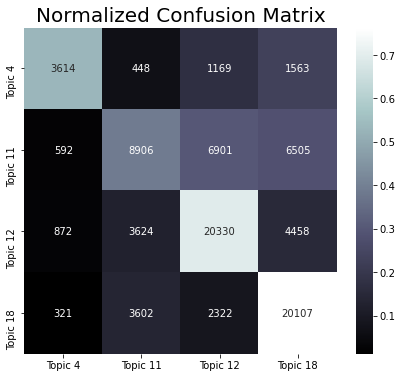

In [30]:
plot_confusion_matrix(cm, 
                      ['Topic 4', 'Topic 11', 'Topic 12', 'Topic 18'],
                      title='Normalized Confusion Matrix')

In [32]:
accuracy_score(y_test,y_pred)

0.6205849954297232

OK, not fantastic, but also not terrible for a first shot. And considering the fact that the tweet texts are not included; the topic is simply being predicted from the dialect, sentiment, and user characteristics.

Following the sklearn documentation blurb copied above, we know that the **micro average** of the precision,  f1 score, and recall are all around 0.62 (i.e. the value of the overall accuracy). This is basically in line with the **weighted average** which falls between 0.61 and 0.62 for the 3 metrics.

Let's see if we can improve on this using a GridSearchCV.

# 6. Hyperparameter Tuning

## 6.1. Running GridSearchCV

Let's run a GridSearchCV with a number of different parameter combinations. Since we're running this on a cluster we can be pretty experimental since we don't really have to worry about the number of total iterations to run in terms of time.

In [41]:
# define model parameters
params = {
    'objective': ['multi:softmax', 'multi:softprob'],
    'num_class': [4],
    'n_estimators': [3,5,7,10], #number of rounds
    'max_depth': [3,4,5,6,7],
    'eta': [.3, .2, .1, .05, .01, .005], # sets the learning rate
    'n_jobs': [-1],
    'min_child_weight': [0.3, 0.5, 1, 2, 3],
}

In [60]:
xg_cl = XGBClassifier(num_boost_round=3)

In [64]:
cv = GridSearchCV(xg_cl, 
                  params, 
                  cv=3)

In [65]:
# train model with timer
start_time = time.time()

cv.fit(X_train, 
       y_train, 
       classes=[0,1,2,3]);

duration = time.time() - start_time

print('GridSearchCV conducted \nin {} seconds.'.format(round(duration, 4)))

OSError: [Errno 22] Bad Request

This is annoying. From [this Github thread](https://github.com/dask/dask-ml/issues/667) it seems like Dask-ML's XGBoost doesn't jive well with Dask-ML's GridSearchCV.

The thread suggests working with the original **xgboost** library. But we tried that and also can't get to work.

## 5.4. XGBoost CV Locally

From the XGBoost docs, it seems that XGBoost has its own Cross-Validation class. 

```
xgboost.cv(params, dtrain, num_boost_round=10, nfold=3, stratified=False, folds=None, metrics=(), obj=None, feval=None, maximize=None, early_stopping_rounds=None, fpreproc=None, as_pandas=True, verbose_eval=None, show_stdv=True, seed=0, callbacks=None, shuffle=True)
```

**BUT** after trying this out, it turns out that this can't handle Dask dataframes and, unfortunately, the dask API of XGBoost doesn't have a .cv() class.

So I think the only thing left to do is to bring our train and test sets to this computer and process the model training locally. Curious to see how long that will take.

In [32]:
# bring train/test sets locally
X_train_df = X_train.compute()
X_test_df = X_test.compute()
y_train_df = y_train.compute()
y_test_df = y_test.compute()

In [47]:
# define model parameters
params = {
    'objective': ['multi:softmax'],
    'num_class': [4],
    'n_estimators': [3,5,7,10], #number of rounds
    'max_depth': [3,5,7,10,15],
    'eta': [.3, .2, .1, .05, .01, .005], # sets the learning rate
    'n_jobs': [-1],
    'min_child_weight': [0.5, 1, 2, 3, 5],
}

In [48]:
# define grid search object
cv = GridSearchCV(estimator=xgb.XGBClassifier(use_label_encoder=False, labels=[0,1,2,3]), 
                  param_grid=params,
                  scoring='accuracy',
                  n_jobs=-1,
                  )

In [49]:
# train model with timer
start_time = time.time()

cv.fit(X_train_df, y_train_df)

duration = time.time() - start_time

print('GridSearchCV trained in {} seconds.'.format(round(duration, 4)))

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError


[00:55:41] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { labels } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:55:44] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
GridSearchCV trained in 26715.8266 seconds.


In [64]:
import datetime
print(str(datetime.timedelta(seconds=duration)))

7:25:15.826620


That only took 7.5 hours! ;)

Let's get the best estimator and see if it did any better than our out-of-the-box model.

In [50]:
cv.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=0.2, gamma=0,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              labels=[0, 1, 2, 3], learning_rate=0.200000003, max_delta_step=0,
              max_depth=10, min_child_weight=5, missing=nan,
              monotone_constraints='()', n_estimators=10, n_jobs=-1,
              num_class=4, num_parallel_tree=1, objective='multi:softprob',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, ...)

In [57]:
y_pred = cv.best_estimator_.predict(X_test_df)

In [58]:
print(classification_report(y_test_df, y_pred, labels=[0,1,2,3]))

              precision    recall  f1-score   support

           0       0.65      0.58      0.62      6794
           1       0.56      0.43      0.48     22904
           2       0.68      0.71      0.70     29284
           3       0.65      0.76      0.70     26352

    accuracy                           0.64     85334
   macro avg       0.63      0.62      0.62     85334
weighted avg       0.63      0.64      0.63     85334



In [59]:
cm = confusion_matrix(y_test_df, y_pred)

In [60]:
def plot_confusion_matrix(cm, classes, normalized=True, cmap='bone', title='Plot Title'):
    plt.figure(figsize=[7, 6])
    plt.title(title, fontsize=20)
    norm_cm = cm
    if normalized:
        norm_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        sns.heatmap(norm_cm, annot=cm, fmt='g', xticklabels=classes, yticklabels=classes, cmap=cmap)

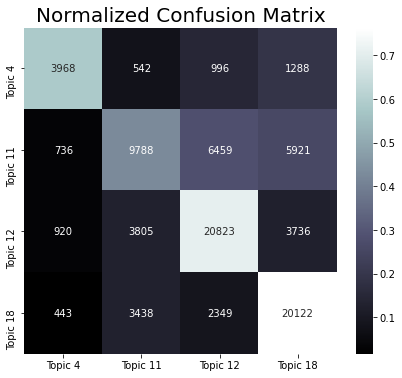

In [61]:
plot_confusion_matrix(cm, 
                      ['Topic 4', 'Topic 11', 'Topic 12', 'Topic 18'],
                      title='Normalized Confusion Matrix')

Alright, just a slight increase in performance, from 62% to 64%. Not a fantastic increase in performance, especially considering the runtime.

Interesting to see that especially Topic 4 (Qatar / Terrorism) seems pretty well classified.

# Conclusions

We've seen that it is possible to predict the sub-topics of the Political Tweet from the non-text features with an accuracy of 64%. Not really a model worth deploying, but it is interesting to see such a relative strong correlation, considering the fact that we're not looking at the content of the tweets. It would be worth doing further exploration to see which of the features contributes most substantially to this predictive power. I wouldn't be suprised if it's **Dialect**, given the fact that there seems to be some geographical diversification within the topics.

The biggest lesson, however, is that **distributed machine learning** poses some unique challenges. As we also saw in the previous notebook, depending on the size of the dataset and the libraries you're hoping to work with, things might not run as smoothly as you're used to, if you're coming from the well-paved Pandas and Sklearn universe.

Although I would've loved to have more substantial findings at this point, it's been a massively instructive journey to work through all this. To connect with maintainers and other data scientists on forums and Github in order to understand the limitations of libraries...and begin to figure out ways to work around those limitations.

I'll definitely be back to fine-tune this project and see if I can reach the goal I set out to begin with: extracting the purely political **misinformation** tweets from this dataset of 36 million tweets.